![image](Images/1.png)

# What is Julia set?

![image](Images/333.png)

# General approach:
    Julia Set construction function takes the following parameters:
    1) complex value c - one value for all Julia Set
    2) vertical bounds (min, max) located along the imaginary axis
        horizontal borders are calculated using the vertical bounds and resolution
    3) center (along the horizontal axis)
    3) resolution (horizontal, vertical)
    4) an amount of iterations to create Julia Set

![image](Images/2.png)

# Julia Set using CuPy (GPU)

![image](Images/3.png)

In [1]:
import cupy as cp

# the complex plain same size with image to be calculated
def create_complex_plain(real_borders = (-1,1), imag_borders = (-1,1), points_ReIm = (100, 100)):
    start_Re, end_Re, points_Re = real_borders[0], real_borders[1], points_ReIm[0] # Re borders + points amount
    start_Im, end_Im, points_Im = imag_borders[0], imag_borders[1], points_ReIm[1] # Im borders + points amount

    linspace_Re_1d = cp.linspace(start_Re, end_Re, points_Re) # Re axis
    linspace_Im_1d = cp.linspace(end_Im, start_Im, points_Im) # Im axis
    linspace_Re_2d, linspace_Im_2d = cp.meshgrid(linspace_Re_1d,linspace_Im_1d) # Re, Im grid
    
    complex_plain = cp.empty([points_Im, points_Re], dtype = cp.complex64) # fill in the complex plain
    complex_plain.real = linspace_Re_2d # real part
    complex_plain.imag = linspace_Im_2d # imaginary part
    return complex_plain

# Julia Set function
def JuliaSetCupy(c = complex(0.0, 0.0), vertical_bounds = (-1.0, 1.0), center = 0, resolution = (100, 100), max_iters = 10):
    
    start_Im, end_Im = vertical_bounds[0], vertical_bounds[1] # vertical bounds
    horizontal_size = (vertical_bounds[1] - vertical_bounds[0]) / (resolution[1] / resolution[0]) # total horizontal size
    start_Re, end_Re = center - horizontal_size / 2, center + horizontal_size / 2 # horizontal bounds
    
    z = create_complex_plain(real_borders = (start_Re, end_Re), imag_borders = (start_Im, end_Im),
                             points_ReIm = (resolution[0], resolution[1])) # complex plin
    
    julia_set = cp.zeros([resolution[1], resolution[0]]) # initial array for Julia Set on the GPU 
    inf_border = (1 + (1 + 4 * abs(c))**0.5) / 2 # infinity criterium
    # Julia Set algorithm
    for i in range(max_iters):
        z = z * z + c
        z[cp.isnan(abs(z))] = inf_border + 1
        julia_set = julia_set + (abs(z) * 1 > inf_border)
    return julia_set.get() # get data from GPU

In [2]:
image1 = JuliaSetCupy(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = 50)

In [3]:
%timeit JuliaSetCupy(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = 50)

149 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'Real(z_inf)')

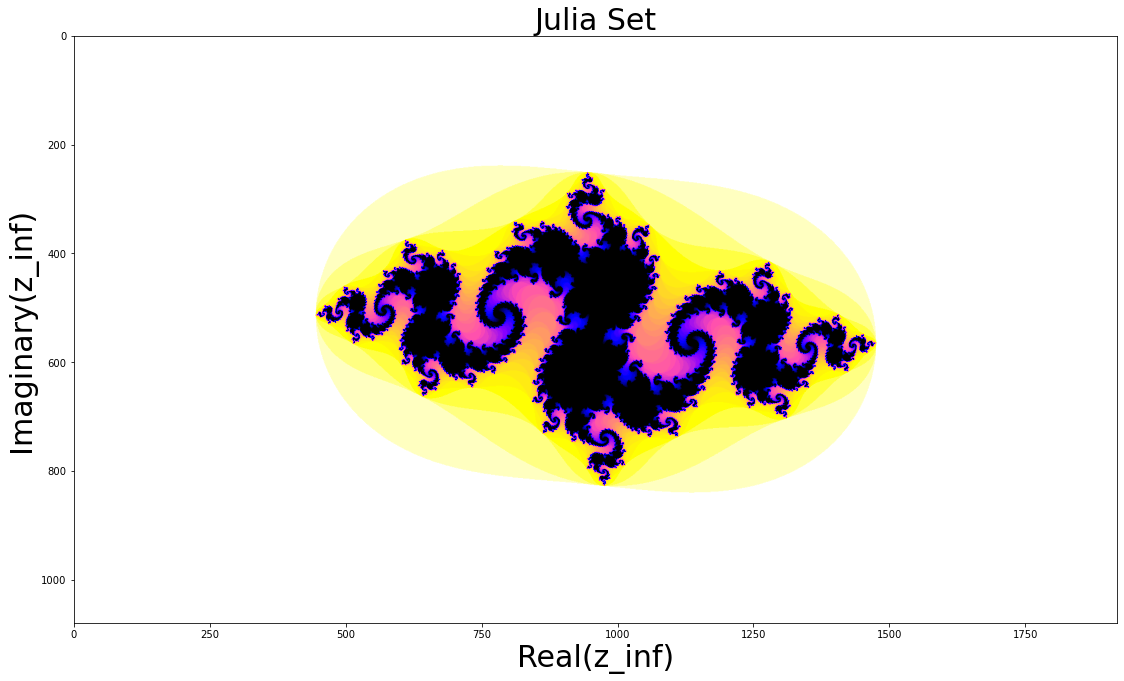

In [4]:
%pylab inline
plt.figure(figsize=(19.2, 10.8))
plt.title('Julia Set', fontsize=30)
plt.imshow(image1, cmap= 'gnuplot2')
plt.ylabel('Imaginary(z_inf)', fontsize=30)
plt.xlabel('Real(z_inf)', fontsize=30)

# Julia Set using JIT + Numpy (CPU)

![image](Images/4.png)

In [5]:
import numpy as np
from numba import njit

@njit(fastmath=True)
def JuliaSet(c = complex(0.0, 0.0), vertical_bounds = (-1.0, 1.0), center = 0, resolution = (100, 100), max_iters = 10):
    
    start_Im, end_Im = vertical_bounds[0], vertical_bounds[1] # vertical bounds
    horizontal_size = (vertical_bounds[1] - vertical_bounds[0]) / (resolution[1] / resolution[0]) # total horizontal size
    start_Re, end_Re = center - horizontal_size / 2, center + horizontal_size / 2 # horizontal bounds
    
    pointsRe, pointsIm = resolution[0], resolution[1]
    infinity_border = (1 + np.sqrt(1 + 4 * abs(c))) / 2 # infinity criterium
    image = np.zeros((resolution[1], resolution[0])) # initial array for Julia Set on the CPU 
    # Julia Set algorithm
    for iq, Re in enumerate(np.linspace(start_Re, end_Re, pointsRe)):
        for ip, Im in enumerate(np.linspace(end_Im, start_Im, pointsIm)):
            z0 = complex(Re, Im)
            for k in range(max_iters):
                z0 = z0 ** 2 + c
                if abs(z0) >= infinity_border:
                    image[ip, iq] =  max_iters - k
                    break
    return image

In [6]:
image2 = JuliaSet(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = 50)

In [7]:
%timeit JuliaSet(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = 50)

116 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'Real(z_inf)')

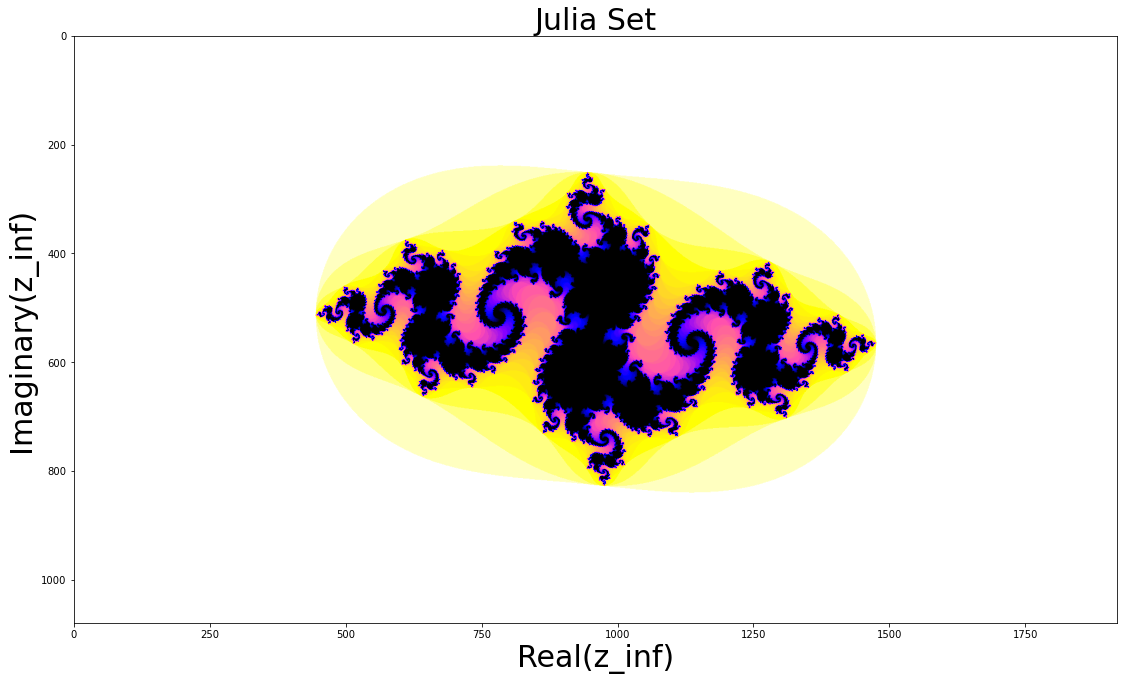

In [8]:
%pylab inline
plt.figure(figsize=(19.2, 10.8))
plt.title('Julia Set', fontsize=30)
plt.imshow(image2, cmap= 'gnuplot2')
plt.ylabel('Imaginary(z_inf)', fontsize=30)
plt.xlabel('Real(z_inf)', fontsize=30)

# Julia Set using JIT Numba + CuPy (GPU)

![image](Images/5.png)

In [9]:
from numba import cuda
import cupy as cp

# Julia Set algorithm
@cuda.jit(device=True)
def julia(c, x, y, max_iters):
    z = complex(x, y)
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return max_iters - i 
    return 0

@cuda.jit
def julia_set(c, minRe, maxRe, minIm, maxIm, center, image, max_iters):
        
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (maxRe - minRe) / width
    pixel_size_y = (maxIm - minIm) / height

    startX = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
    startY = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    
    # along grid elements
    for x in range(startX, width, gridX):
        real = minRe + x * pixel_size_x + center
        for y in range(startY, height, gridY):
            imag = maxIm - y * pixel_size_y 
            image[y, x] = julia(c, real, imag, max_iters)
            
def JuliaSetCupyJit(c = complex(0.0, 0.0), vertical_bounds = (-1.0, 1.0), center = 0, resolution = (100, 100), max_iters = 10):
    start_Im, end_Im = vertical_bounds[0], vertical_bounds[1] # vertical bounds
    horizontal_size = (vertical_bounds[1] - vertical_bounds[0]) / (resolution[1] / resolution[0]) # total horizontal size
    start_Re, end_Re = center - horizontal_size / 2, center + horizontal_size / 2 # horizontal bounds
    
    gpu_image = cp.zeros((resolution[1], resolution[0]), dtype = cp.uint8) # initial array for Julia Set on the GPU 
    # grid sizes
    blockdim = (16, 16)
    griddim = (16, 16)
    # Julia Set algorithm
    julia_set[griddim, blockdim](c, start_Re, end_Re, start_Im, end_Im, center, gpu_image, max_iters)
    return gpu_image.get() # get data from GPU

In [10]:
image3 = JuliaSetCupyJit(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = 50)

In [11]:
%timeit JuliaSetCupyJit(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = 50)

4.22 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'Real(z_inf)')

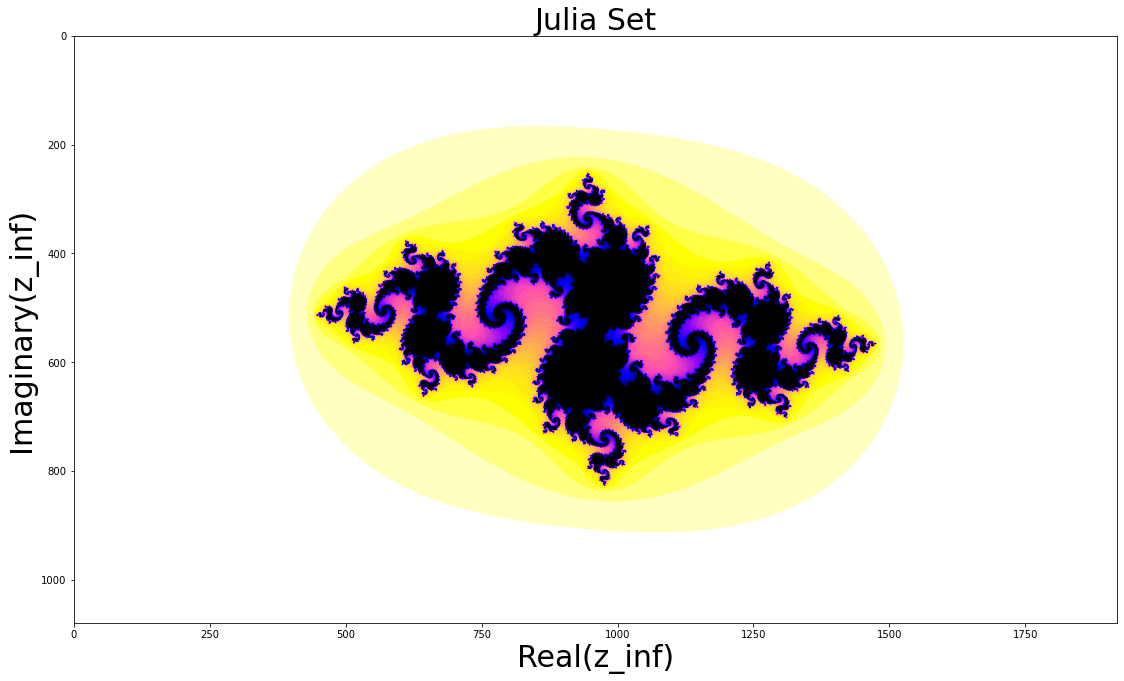

In [12]:
%pylab inline
plt.figure(figsize=(19.2, 10.8))
plt.title('Julia Set', fontsize=30)
plt.imshow(image3, cmap= 'gnuplot2')
plt.ylabel('Imaginary(z_inf)', fontsize=30)
plt.xlabel('Real(z_inf)', fontsize=30)

# Perfomance: constant number of iterations, different square resolurions

![image](Images/6.png)

In [13]:
time_cupy = []
for size in range(200, 5000, 200):
    t = %timeit -o -q JuliaSetCupy(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (size, size), max_iters = 50);
    time_cupy.append(t)
    print(t)

8.66 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.4 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
28.4 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.8 ms ± 732 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
72.3 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
142 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
185 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
232 ms ± 8.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
291 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
353 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
426 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
477 ms ± 8.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
577 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
681 ms ± 19.4 ms per loop (m

In [14]:
time_numpy_jit = []
for size in range(200, 5000, 200):
    t = %timeit -o -q JuliaSet(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (size, size), max_iters = 50);
    time_numpy_jit.append(t)
    print(t)

4.03 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.7 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
36.4 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.4 ms ± 834 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
90.4 ms ± 965 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
128 ms ± 940 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
174 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
228 ms ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
278 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
340 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
420 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
502 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
648 ms ± 64.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
685 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
800 ms ± 21.7 ms per loop (mean

In [15]:
time_cupy_jit = []
for size in range(200, 5000, 200):
    t = %timeit -o -q JuliaSetCupyJit(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (size, size), max_iters = 50);
    time_cupy_jit.append(t)
    print(t)

556 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
923 µs ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.52 ms ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.19 ms ± 2.48 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.24 ms ± 88.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.71 ms ± 93.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.18 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.21 ms ± 31.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.88 ms ± 64.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.8 ms ± 71.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.9 ms ± 93.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.7 ms ± 576 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.1 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.3 ms ± 89.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops e

# Calculation time vs Image size

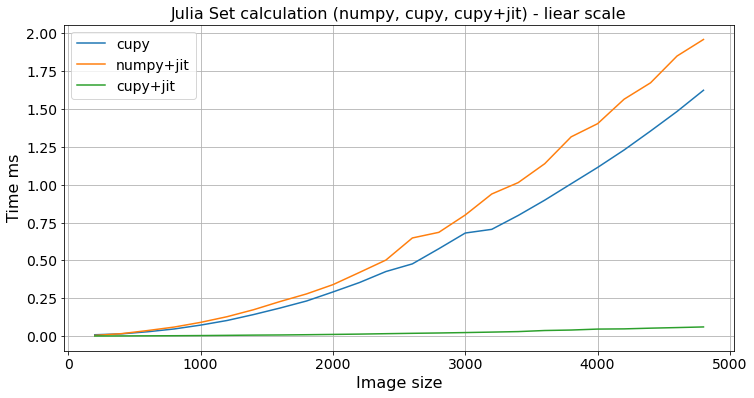

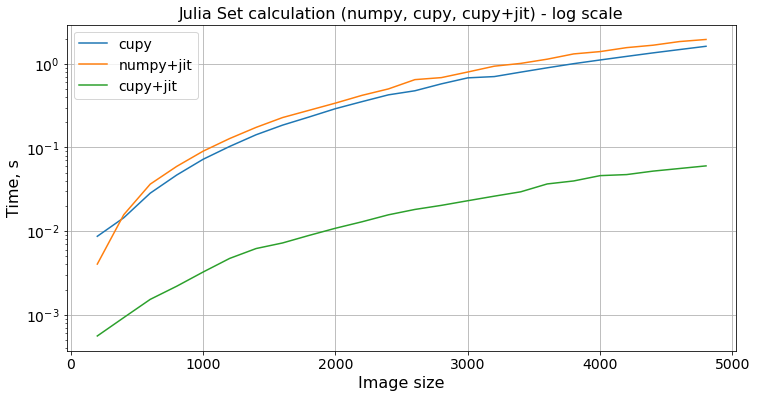

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(np.arange(200, 5000, 200), [i.average for i in time_cupy])
plt.plot(np.arange(200, 5000, 200), [i.average for i in time_numpy_jit])
plt.plot(np.arange(200, 5000, 200), [i.average for i in time_cupy_jit])

plt.title('Julia Set calculation (numpy, cupy, cupy+jit) - liear scale', fontsize=16)
#plt.yscale('log')
plt.xlabel('Image size', fontsize=16)
plt.ylabel('Time ms', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy+jit', 'cupy+jit'], fontsize=14);
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.arange(200, 5000, 200), [i.average for i in time_cupy])
plt.plot(np.arange(200, 5000, 200), [i.average for i in time_numpy_jit])
plt.plot(np.arange(200, 5000, 200), [i.average for i in time_cupy_jit])

plt.title('Julia Set calculation (numpy, cupy, cupy+jit) - log scale', fontsize=16)
plt.yscale('log')
plt.xlabel('Image size', fontsize=16)
plt.ylabel('Time, s', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy+jit', 'cupy+jit'], fontsize=14);
plt.grid()
plt.show()

# Relative speed down vs Image size

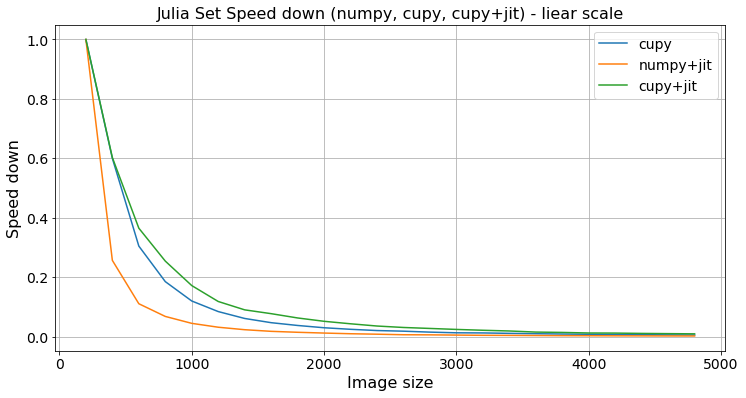

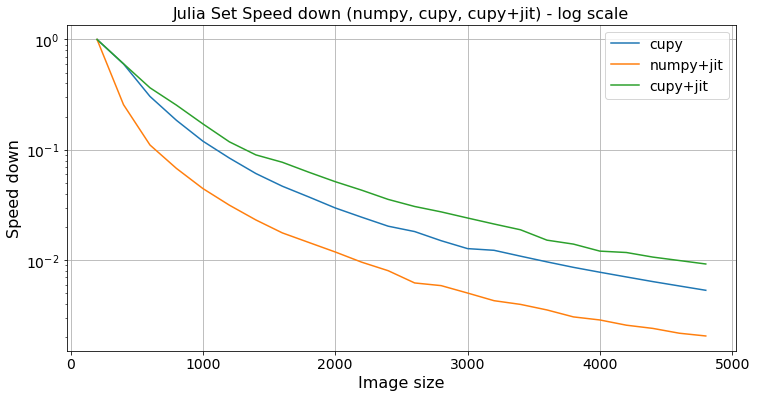

In [17]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(200, 5000, 200), [time_cupy[0].average/i.average for i in time_cupy])
plt.plot(np.arange(200, 5000, 200), [time_numpy_jit[0].average/i.average for i in time_numpy_jit])
plt.plot(np.arange(200, 5000, 200), [time_cupy_jit[0].average/i.average for i in time_cupy_jit])

plt.title('Julia Set Speed down (numpy, cupy, cupy+jit) - liear scale', fontsize=16)
#plt.yscale('log')
plt.xlabel('Image size', fontsize=16)
plt.ylabel('Speed down', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy+jit', 'cupy+jit'], fontsize=14);
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.arange(200, 5000, 200), [time_cupy[0].average/i.average for i in time_cupy])
plt.plot(np.arange(200, 5000, 200), [time_numpy_jit[0].average/i.average for i in time_numpy_jit])
plt.plot(np.arange(200, 5000, 200), [time_cupy_jit[0].average/i.average for i in time_cupy_jit])

plt.title('Julia Set Speed down (numpy, cupy, cupy+jit) - log scale', fontsize=16)
plt.yscale('log')
plt.xlabel('Image size', fontsize=16)
plt.ylabel('Speed down', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy+jit', 'cupy+jit'], fontsize=14);
plt.grid()
plt.show()

# Perfomance: variable number of iterations, constant resolurion

In [18]:
time_cupy_it = []
for iters in range(50, 1000, 50):
    t = %timeit -o -q JuliaSetCupy(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = iters);
    time_cupy_it.append(t)
    print(t)

155 ms ± 8.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
320 ms ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
467 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
642 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
776 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
905 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.02 s ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.14 s ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.3 s ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.48 s ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.7 s ± 69.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.85 s ± 78.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.07 s ± 79.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.11 s ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.22 s ± 36 ms per loop (mean ± std. dev. of 7 runs

In [19]:
time_numpy_jit_it = []
for iters in range(50, 1000, 50):
    t = %timeit -o -q JuliaSet(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = iters);
    time_numpy_jit_it.append(t)
    print(t)

124 ms ± 6.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
174 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
225 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
238 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
257 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
271 ms ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
304 ms ± 43.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
285 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
290 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
293 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
298 ms ± 6.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
295 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
298 ms ± 8.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
284 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
283 ms ± 1.8 ms per loop (mean ± std. dev. of 

In [20]:
time_cupy_jit_it = []
for iters in range(50, 1000, 50):
    t = %timeit -o -q JuliaSetCupyJit(c = complex(-0.8, 0.156), vertical_bounds = (-1.6, 1.6), center = 0, resolution = (1920, 1080), max_iters = iters);
    time_cupy_jit_it.append(t)
    print(t)

3.98 ms ± 74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.43 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.71 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.1 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.2 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.3 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.2 ms ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.2 ms ± 6.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.9 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.5 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.8 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.7 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.4 ms ± 9.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.7 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.7 ms ±

# Calculation time vs Number of iterations

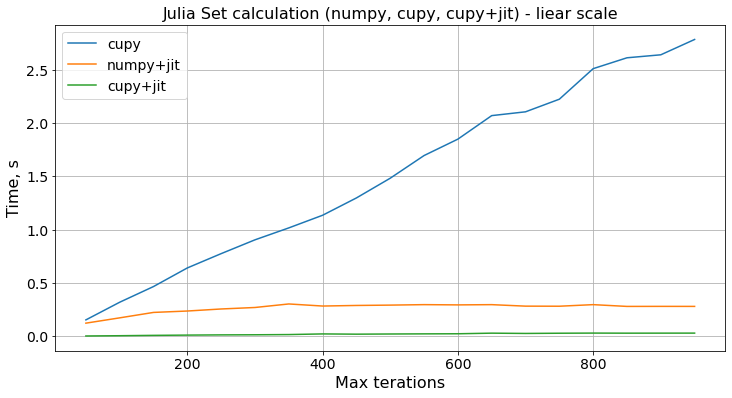

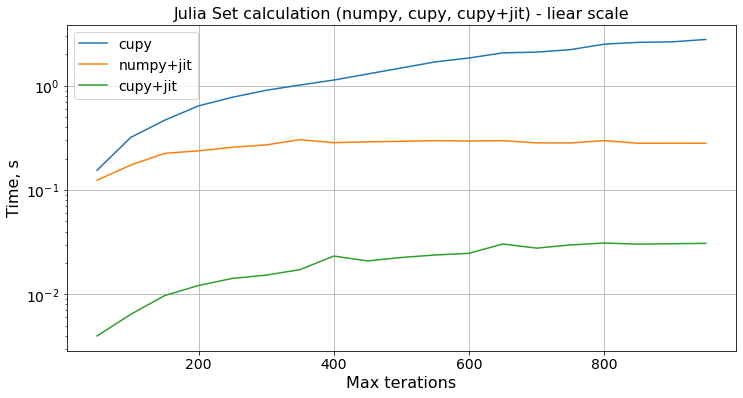

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(np.arange(50, 1000, 50), [i.average for i in time_cupy_it])
plt.plot(np.arange(50, 1000, 50), [i.average for i in time_numpy_jit_it])
plt.plot(np.arange(50, 1000, 50), [i.average for i in time_cupy_jit_it])

plt.title('Julia Set calculation (numpy, cupy, cupy+jit) - liear scale', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max terations', fontsize=16)
plt.ylabel('Time, s', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy+jit', 'cupy+jit'], fontsize=14);
plt.grid()
plt.show()


plt.figure(figsize=(12,6))
plt.plot(np.arange(50, 1000, 50), [i.average for i in time_cupy_it])
plt.plot(np.arange(50, 1000, 50), [i.average for i in time_numpy_jit_it])
plt.plot(np.arange(50, 1000, 50), [i.average for i in time_cupy_jit_it])

plt.title('Julia Set calculation (numpy, cupy, cupy+jit) - liear scale', fontsize=16)
plt.yscale('log')
plt.xlabel('Max terations', fontsize=16)
plt.ylabel('Time, s', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy+jit', 'cupy+jit'], fontsize=14);
plt.grid()
plt.show()

# Relative speed down vs Number of iterations

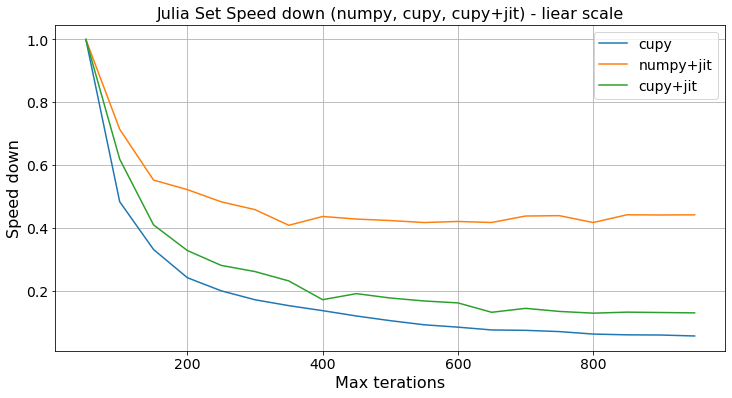

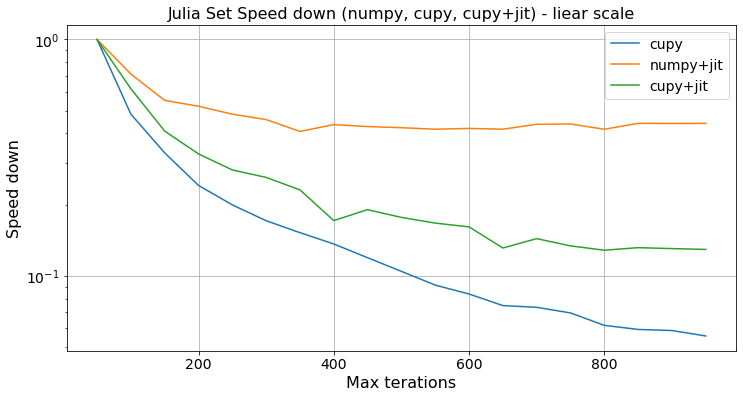

In [22]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(50, 1000, 50), [time_cupy_it[0].average/i.average for i in time_cupy_it])
plt.plot(np.arange(50, 1000, 50), [time_numpy_jit_it[0].average/i.average for i in time_numpy_jit_it])
plt.plot(np.arange(50, 1000, 50), [time_cupy_jit_it[0].average/i.average for i in time_cupy_jit_it])

plt.title('Julia Set Speed down (numpy, cupy, cupy+jit) - liear scale', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max terations', fontsize=16)
plt.ylabel('Speed down', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy+jit', 'cupy+jit'], fontsize=14);
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.arange(50, 1000, 50), [time_cupy_it[0].average/i.average for i in time_cupy_it])
plt.plot(np.arange(50, 1000, 50), [time_numpy_jit_it[0].average/i.average for i in time_numpy_jit_it])
plt.plot(np.arange(50, 1000, 50), [time_cupy_jit_it[0].average/i.average for i in time_cupy_jit_it])

plt.title('Julia Set Speed down (numpy, cupy, cupy+jit) - liear scale', fontsize=16)
plt.yscale('log')
plt.xlabel('Max terations', fontsize=16)
plt.ylabel('Speed down', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy+jit', 'cupy+jit'], fontsize=14);
plt.grid()
plt.show()

In terms of the calculation time - best option - Cuda + JIT compiler.

# Animation creation

# The best way - CuPy + Numba

![image](Images/123.png)

In [23]:
class Zoom:
    def __init__(self, law = None, max_frames = None, max_zoom = None,
                Re_min = None, Re_max = None, Im_min = None, Im_max = None):         
        self.law = law
        self.max_frames = max_frames
        self.max_zoom = max_zoom
        
        self.Re_min = Re_min
        self.Re_max = Re_max
        self.Im_min = Im_min
        self.Im_max = Im_max
        
    def setLaw(self, law):
        self.law = law
        pass
    
    def setMaxFrames(self, max_frames):
        self.max_frames = max_frames
        pass
    
    def setMaxZoom(self, max_zoom):
        self.max_zoom = max_zoom
        pass
    
    def setSpace(self, Re_min, Re_max, Im_min, Im_max):
        self.Re_min = Re_min
        self.Re_max = Re_max
        self.Im_min = Im_min
        self.Im_max = Im_max
        pass
    
    def zoom_Function(self, step):
        if self.law == 0 or self.law == 'linear':
            zoom = (step / self.max_frames) * (self.max_zoom - 1) + 1
        elif self.law == 1:
            zoom = (step / self.max_frames * 2)**0.5 * self.max_zoom + 1
        elif self.law == 2:
            zoom = (step / self.max_frames * 2)**1 * self.max_zoom + 1
        elif self.law == 3:
            zoom = (step / self.max_frames * 2)**2 * self.max_zoom + 1
        elif self.law == 4:
            zoom = (step / self.max_frames * 2)**3 * self.max_zoom + 1
        elif self.law == 5:
            zoom = (exp(step/(self.max_frames * 0.1)) / self.max_frames) * self.max_zoom + 1
        return zoom
    
    def calculateScaleFactor(self, step):
        zoom = self.zoom_Function(step)
        scalefactor = 1 / zoom
        return scalefactor
        
    def into_center(self, step, center):
        assert self.Re_min != None, "Please, set Re_min"
        assert self.Re_max != None, "Please, set Re_max"
        assert self.Im_min != None, "Please, set Im_min"
        assert self.Im_max != None, "Please, set Im_max"
        assert self.law != None, "Please, set law"
        assert self.max_frames != None, "Please, set max_frames"  
        assert self.max_zoom != None, "Please, set max_zoom"

        scalefactor = self.calculateScaleFactor(step = step)
        
        re_center = center[0]
        im_center = center[1]
        
        re_min_ = (self.Re_min - re_center) * scalefactor + re_center
        im_min_ = (self.Im_min - im_center) * scalefactor + im_center
        re_max_ = (self.Re_max - re_center) * scalefactor + re_center
        im_max_ = (self.Im_max - im_center) * scalefactor + im_center
        return re_min_, re_max_, im_min_, im_max_
    
    def print_zoom_law(self):
        x = np.arange(1, self.max_frames, 1)
        scalefactor = 1/self.zoom_Function(x)
        re_center, im_center = 0, 0
        
        re_min_ = (self.Re_min - re_center) * scalefactor + re_center
        im_min_ = (self.Im_min - im_center) * scalefactor + im_center
        re_max_ = (self.Re_max - re_center) * scalefactor + re_center
        im_max_ = (self.Im_max - im_center) * scalefactor + im_center
        
        plt.plot(re_max_ - re_min_)
        plt.plot(im_max_ - im_min_)
        print(re_max_[self.max_frames-2] - re_min_[self.max_frames-2])

# Zoom class
## 1) different zoom laws; 2) boarders recalculuating on each frame

![image](Images/11.gif)

## JIT Numba +  CuPu

In [24]:
from numba import cuda
import cupy as cp

# Julia Set algorithm
@cuda.jit(device=True)
def julia(c, x, y, max_iters):
    z = complex(x, y)
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return max_iters - i 
    return 0

@cuda.jit
def julia_set(c, minRe, maxRe, minIm, maxIm, center, image, max_iters):
        
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (maxRe - minRe) / width
    pixel_size_y = (maxIm - minIm) / height

    startX = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
    startY = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    
    # along grid elements
    for x in range(startX, width, gridX):
        real = minRe + x * pixel_size_x + center
        for y in range(startY, height, gridY):
            imag = maxIm - y * pixel_size_y 
            image[y, x] = julia(c, real, imag, max_iters)
            
def JuliaSetCupyJit(c = complex(0.0, 0.0), vertical_bounds = (-1.0, 1.0), center = 0, resolution = (100, 100), max_iters = 10):
    start_Im, end_Im = vertical_bounds[0], vertical_bounds[1] # vertical bounds
    horizontal_size = (vertical_bounds[1] - vertical_bounds[0]) / (resolution[1] / resolution[0]) # total horizontal size
    start_Re, end_Re = center - horizontal_size / 2, center + horizontal_size / 2 # horizontal bounds
    
    gpu_image = cp.zeros((resolution[1], resolution[0]), dtype = cp.uint8) # initial array for Julia Set on the GPU 
    # grid sizes
    blockdim = (16, 16)
    griddim = (16, 16)
    # Julia Set algorithm
    julia_set[griddim, blockdim](c, start_Re, end_Re, start_Im, end_Im, center, gpu_image, max_iters)
    return gpu_image.get() # get data from GPU

## Real time vizualization + save video using OpenCV

In [32]:
# !pip3 install opencv-python

In [33]:
%pylab inline
import cv2
# import numpy as np

SAVE = False # save or not a video of the simulation

c = complex(-0.74543, 0.11301) # complex number for Julia Set

center1 = (0,0.12) # central point of zooming (Re, Im)
max_frames = 1800 
max_zoom = 250000
res = (1280, 720) # resolution

# create zoom
zoom = Zoom()
zoom.setLaw(law = 4) # set zooming law
zoom.setMaxFrames(max_frames = max_frames) # set maxframes
zoom.setMaxZoom(max_zoom = max_zoom) # set maxzoom
zoom.setSpace(Re_min = -5, Re_max = 5, Im_min = -5, Im_max = 5) # set borders

# video saving
if SAVE == True:
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter('Julia_Set.mp4',fourcc, 33.0, (res[0], res[1]))

i = 0
while(i <= max_frames):
    i += 1
    
    minRe, maxRe, minIm, maxIm = zoom.into_center(step = i, center = center1) # zoom coordinates
    image = JuliaSetCupyJit(c = c, vertical_bounds = (minIm, maxIm),
                            center = center1[0], resolution = (res[0], res[1]), max_iters = 1000)    
#     image_color = cv2.applyColorMap(image, cv2.COLORMAP_INFERNO)
#     image_color = cv2.applyColorMap(image, cv2.COLORMAP_RAINBOW)
#     image_color = cv2.applyColorMap(image, cv2.COLORMAP_HSV)
#     image_color = cv2.applyColorMap(image, cv2.COLORMAP_PARULA)
#     image_color = cv2.applyColorMap(image, cv2.COLORMAP_PLASMA)
    image_color = cv2.applyColorMap(image, cv2.COLORMAP_TURBO)  
    
    cv2.imshow('Julia Set', image_color)
    if cv2.waitKey(1) & 0xFF == ord('q'): # keyboard exit
        break
    if i >= max_frames: # max frames exit
        break
    if SAVE == True:
        out.write(image_color)
        
if SAVE == True:
    out.release()
cv2.destroyAllWindows()

Populating the interactive namespace from numpy and matplotlib


![image](Images/321.png)